# AML Assignment 3
- Nandini Jaiswal MDS202335
- Aritra MCS202304

# `Installing` and `Importing`

## The following block installs necessary libraries to set up display in the notebook environment.

In [5]:
!apt-get install x11-utils > /dev/null 2>&1
%pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [6]:
%matplotlib inline

## The `gym[classic_control]` has `Classic Control` environments like `Acrobot-v1`.

In [7]:
!pip3 install gym[classic_control] --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.0 MB/s eta 0:00:00


In [8]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import warnings
warnings.filterwarnings("ignore")

## Switch to `GPU` for faster neural network training.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## `Utility function` for displaying the experiment.

In [10]:
import imageio
import os
from IPython.display import HTML

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    """Takes a list of frames (each frame can be generated with the `env.render()` function from OpenAI gym)
    and converts it into GIF, and saves it to the specified location.
    Args:
        frames (list): A list of frames generated with the env.render() function
        path (str, optional): The folder in which to save the generated GIF. Defaults to './'.
        filename (str, optional): The target filename. Defaults to 'gym_animation.gif'.
    """
    imageio.mimwrite(os.path.join(path, filename), frames, fps=30)

# Setting up `Acrobot` environment



In [11]:
env = gym.make('Acrobot-v1', render_mode='rgb_array')

## Reset the `env` and display the initial state.

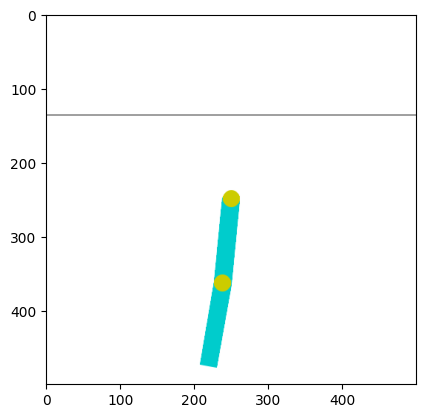

In [12]:
env.reset()

frame = env.render()
frame = np.array(frame[0])

plt.imshow(frame)
plt.grid(False)

## Understanding the `Observation Space` Details

The observation space represents the **state space** of an environment. It defines the range of possible values that the agent can observe at any given time.

---

### **Observation Space Details**

| Key                     | Description                                                                                         |
|-------------------------|-----------------------------------------------------------------------------------------------------|
| **`_np_random`**        | The random number generator used for stochastic behavior. Currently `None` (not initialized).       |
| **`_shape`**            | The shape of the observation space. Here, it is `(6,)`, meaning the observation consists of 6 values. |
| **`bounded_above`**     | A Boolean array indicating if each dimension is **upper-bounded**. All `True` here (values have upper limits). |
| **`bounded_below`**     | A Boolean array indicating if each dimension is **lower-bounded**. All `True` here (values have lower limits). |
| **`dtype`**             | The data type of the observations. Here, it is `float32`, meaning 32-bit floating-point numbers.     |
| **`high`**              | An array representing the **upper bounds** for each dimension of the observation space.             |
| **`low`**               | An array representing the **lower bounds** for each dimension of the observation space.             |
| **`high_repr`**         | A string representation of the `high` values for better display.                                    |
| **`low_repr`**          | A string representation of the `low` values for better display.                                     |

---

The `observation variables` are given below:

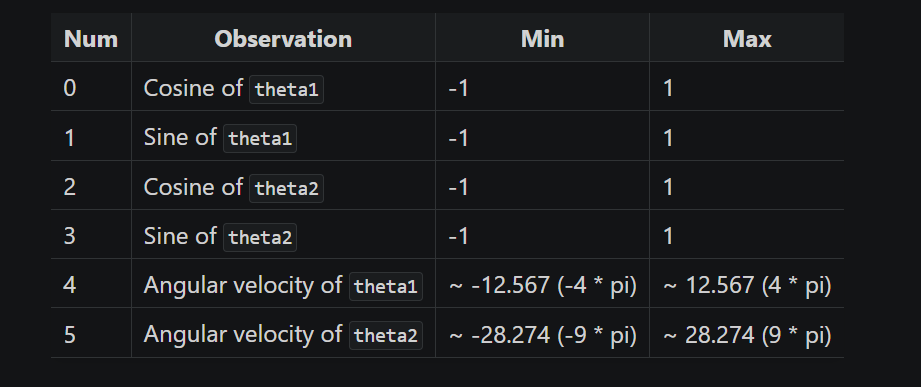

In [13]:
print("Observation Space Details:")
pprint(vars(env.observation_space))

Observation Space Details:
{'_np_random': None,
 '_shape': (6,),
 'bounded_above': array([ True,  True,  True,  True,  True,  True]),
 'bounded_below': array([ True,  True,  True,  True,  True,  True]),
 'dtype': dtype('float32'),
 'high': array([ 1.      ,  1.      ,  1.      ,  1.      , 12.566371, 28.274334],
      dtype=float32),
 'high_repr': '[ 1.        1.        1.        1.       12.566371 28.274334]',
 'low': array([ -1.      ,  -1.      ,  -1.      ,  -1.      , -12.566371,
       -28.274334], dtype=float32),
 'low_repr': '[ -1.        -1.        -1.        -1.       -12.566371 '
             '-28.274334]'}


## Similarly, the `action space` details:

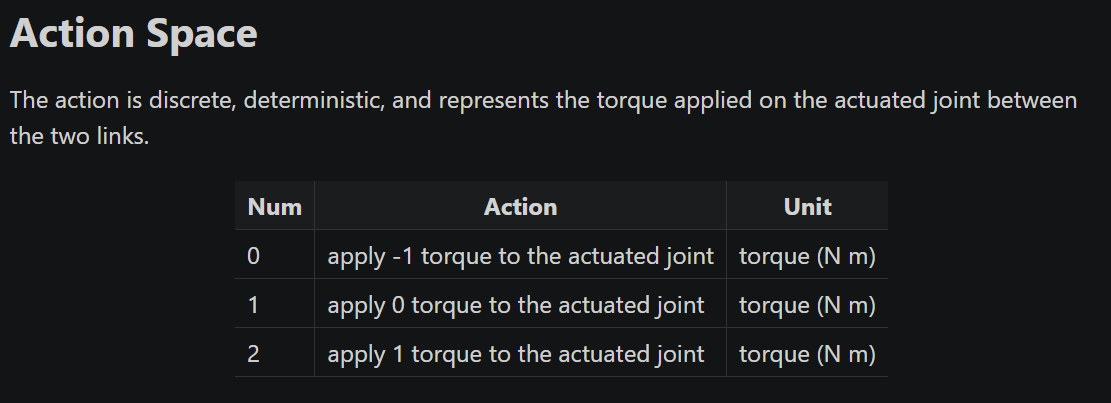

In [14]:
print("Action Space Details:")
pprint(vars(env.action_space))

Action Space Details:
{'_np_random': None, '_shape': (), 'dtype': dtype('int64'), 'n': 3, 'start': 0}


## Rewards

- The goal is to have the free end reach a designated target height in as few steps as possible, and as such all steps that do not reach the goal incur a reward of `-1`.
- Achieving the target height results in termination with a reward of `0`.

## Demo of a `Random Agent`

As all the torques are randomly applied, even after 500 steps, the `bot` will succeed with extremely lo probability,.

In [15]:
frames = []
env.reset()
total_reward = 0

simulation_steps = 500

for i in range(simulation_steps):
    # Randomly select an action from 3 possible actions.
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    frame = env.render()
    frame = np.array(frame[0])
    frames.append(frame)
    if done:
        break

print("Game terminated after", len(frames), "steps with reward", total_reward)
save_frames_as_gif(frames, path='./', filename='random_agent.gif')

Game terminated after 500 steps with reward -500.0


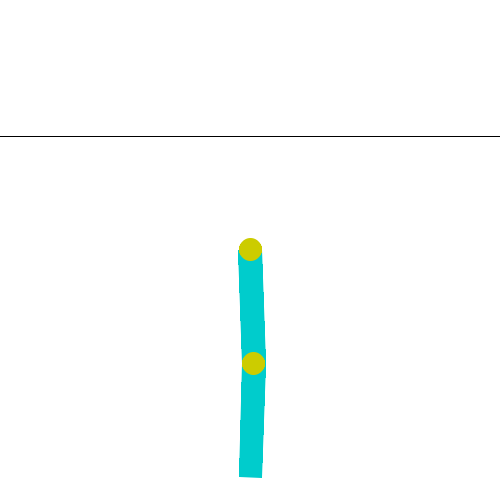

In [3]:
# If viewing in the Jupyter notebook, it will display the GIF only once.
# Please reload it or copy/save the file to view it again.

Image(open('random_agent.gif','rb').read())

# `Deep Q learning` and `Replay` memory.

## Deep Q-Network (DQN)

The `DQN` class implements a **Deep Q-Network** for approximating the Q-function.


### **Parameters**
- **`n_observations`**: The number of observations (or features) in the input, representing the state of the environment.
- **`n_actions`**: The number of possible actions that the agent can take, representing the output size of the network.


### **Layers**
1. **`layer1`**: A fully connected (linear) layer with `128` neurons, which takes the input observations and maps them to a hidden representation.
2. **`layer2`**: Another fully connected layer with `128` neurons, which processes the hidden representation from `layer1`.
3. **`layer3`**: The output layer, mapping the processed features to `n_actions` neurons, representing the Q-values for each possible action.

In [17]:
class DQN(nn.Module):
    """
    Deep Q-Network (DQN) class.

    Parameters:
        n_observations (int): Number of observations (input size).
        n_actions (int): Number of possible actions (output size).
    """

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
            x (tensor): Input tensor with shape (batch_size, n_observations).

        Returns:
            tensor: Output tensor with shape (batch_size, n_actions).
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Define the `hyperparameters`

In [18]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n
state = env.reset()
n_observations = len(state)

# Initialize policy and target networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())

# Define the replay memory transition as a named tuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

optimizer = optim.AdamW(policy_net.parameters(), lr=LR)

## Replay Memory

The `ReplayMemory` class implements **experience replay** for storing and sampling transitions.

In [19]:
class ReplayMemory(object):
    """Replay Memory implementation to store transitions and sample from them"""

    def __init__(self, capacity):
        """Initialize the Replay Memory

        Args:
        capacity (int): Maximum capacity of the Replay Memory
        """
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition

        Args:
        *args: Tuple of state, action, next state, and reward
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a random batch of transitions

        Args:
        batch_size (int): Number of transitions to sample

        Returns:
        List of randomly sampled transitions from the Replay Memory
        """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the length of the Replay Memory"""
        return len(self.memory)

In [20]:
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Initialize a replay memory with a capacity of 10000
memory = ReplayMemory(10000)

steps_done = 0

# Training the `Deep Q Network`

## `select_action` Function

The `select_action` function implements an **epsilon-greedy strategy** for selecting actions in reinforcement learning.
It chooses between:
1. **Exploitation**: Selecting the action with the highest Q-value (greedy choice).
2. **Exploration**: Selecting a random action to discover new possibilities.


  A random number `sample` (between 0 and 1) is compared against a decaying threshold `eps_threshold`. Towards the end, we are more inclined towards `exploiation`.  


   - If `sample > eps_threshold`, we **Exploit**  
     Use the `policy_net` to select the action with the highest Q-value.  
   - Otherwise, we **Explore**  
     Select a random action from the environment's action space.



In [21]:
def select_action(state):
    """
    Select an action to take based on the current state of the environment

    Args:
    - current state of the environment

    Returns:
    - action to take based on the current state
    """
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

### Optimizing Model

The `optimize_model` function updates the **Q-Network** parameters using a `random` minibatch of experience from the replay memory buffer.

1. If the replay buffer has fewer transitions than `BATCH_SIZE`, exit early.

2. Sample a minibatch of transitions (state, action, reward, next_state).

3. Split transitions into states, actions, rewards, and next states and Mmask final states (where no next state exists).

4. - **Current Q-values**: `policy_net` predicts Q-values, and actions taken are selected.  
   - **Next State Q-values**: `target_net` predicts Q-values for next states, selecting the maximum reward for non-final states.

5. Combine rewards and discounted next Q-values:  
   ```
   expected_state_action_values = reward + GAMMA * max_Q(next_state)
   ```

6. We use the **Huber loss** (`SmoothL1Loss`) to measure the difference between predicted and expected Q-values.

7. Backpropagate the loss to update the network’s parameters and apply gradient clipping to prevent exploding gradients.

In [22]:
def optimize_model():
    """
    This function optimizes the Q-Network by performing backpropagation and updating the network's parameters.
    It relies on the global variables defined in the main function.

    Returns:
        None
    """
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch) # current Q

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping to avoid exploding gradient
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

### Training Loop for Q-Learning

- Set the number of episodes (`500` for GPU, `200` otherwise).  
- For each episode:  
  - Reset the environment and initialize the state.  
  - Select actions using `select_action` and compare to the optimal action.  
  - Take the action, observe reward, next state, and termination signal.  
  - Store transitions in memory and optimize the model.  
  - Soft update the target network using a weighted average of parameters.  
  - Track total reward and optimal action count.  
- Calculate and print average reward and optimal action percentage for each episode.  
- Plot results and display "Training Completed."  

In [23]:
episode_durations = []

if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 200

average_rewards = []
optimal_action_percentages = []
for i_episode in range(num_episodes):
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    optimal_action_count = 0
    total_reward = 0

    for t in count():
        action = select_action(state)

        with torch.no_grad():
            optimal_action = policy_net(state).max(1)[1].view(1, 1)
        if action == optimal_action:
            optimal_action_count += 1

        # Take the action and observe the next state, reward, and termination signal
        observation, reward, terminated, _ = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            print(episode_durations[-1])
            break

    # Calculate the average reward for this episode
    average_reward = total_reward / (t + 1)
    average_rewards.append(average_reward)

    # Calculate the optimal action percentage for this episode
    optimal_action_percentage = (optimal_action_count / (t + 1)) * 100
    optimal_action_percentages.append(optimal_action_percentage)

    print(f"Episode {i_episode + 1}/{num_episodes}: Average Reward = {average_reward:.2f}, Optimal Action Percentage = {optimal_action_percentage:.2f}%")

print('Training Completed')

500
Episode 1/200: Average Reward = -1.00, Optimal Action Percentage = 50.60%
500
Episode 2/200: Average Reward = -1.00, Optimal Action Percentage = 71.40%
500
Episode 3/200: Average Reward = -1.00, Optimal Action Percentage = 81.00%
500
Episode 4/200: Average Reward = -1.00, Optimal Action Percentage = 84.80%
500
Episode 5/200: Average Reward = -1.00, Optimal Action Percentage = 91.40%
164
Episode 6/200: Average Reward = -0.99, Optimal Action Percentage = 90.24%
116
Episode 7/200: Average Reward = -0.99, Optimal Action Percentage = 91.38%
229
Episode 8/200: Average Reward = -1.00, Optimal Action Percentage = 94.76%
300
Episode 9/200: Average Reward = -1.00, Optimal Action Percentage = 93.67%
210
Episode 10/200: Average Reward = -1.00, Optimal Action Percentage = 96.19%
119
Episode 11/200: Average Reward = -0.99, Optimal Action Percentage = 94.12%
117
Episode 12/200: Average Reward = -0.99, Optimal Action Percentage = 91.45%
91
Episode 13/200: Average Reward = -0.99, Optimal Action Per

### Run `Trained Agent`

- Initialize environment and set up variables (`frames`, `total_rewards`).  
- For each episode:  
  - Reset the environment and initialize the state.  
  - Run the agent for up to 500 steps:  
    - Select the **greedy action** using the trained policy network.  
    - Perform the action, observe the next state and reward.  
    - Render and store the frame.  
    - Update the state or terminate if `done`.  
  - Track the total reward for the episode.  


In [26]:
from collections import deque

def run_trained_agent(env, policy_net, num_episodes=1, gif_filename='trained_agent.gif'):
    """
    Run the trained agent in the environment, render frames, and save as a GIF.
    Args:
        env: OpenAI Gym environment.
        policy_net: Trained Q-network for decision making.
        num_episodes (int): Number of episodes to run.
        gif_filename (str): Name of the output GIF file.
    """
    frames = []
    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_reward = 0

        for t in range(500):  # Limit episode to 500 steps
            # Select action using the trained model (greedy action)
            with torch.no_grad():
                action = policy_net(state).argmax(dim=1).item()

            next_state, reward, done, info = env.step(action)
            episode_reward += reward

            frame = env.render()
            frame = np.array(frame[0])
            frames.append(frame)

            if not done:
                state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
            else:
                break

        total_rewards.append(episode_reward)
        print(f"Test Episode {episode + 1}: Total Reward = {episode_reward}")

    save_frames_as_gif(frames, filename=gif_filename)
    print(f"GIF saved as {gif_filename}")

    return total_rewards

env = gym.make('Acrobot-v1', render_mode='rgb_array')
test_rewards = run_trained_agent(env, policy_net, num_episodes=1, gif_filename='trained_agent.gif')

print("Test Run Complete. Total Rewards:", test_rewards)
env.close()

Test Episode 1: Total Reward = -66.0
GIF saved as trained_agent.gif
Test Run Complete. Total Rewards: [-66.0]


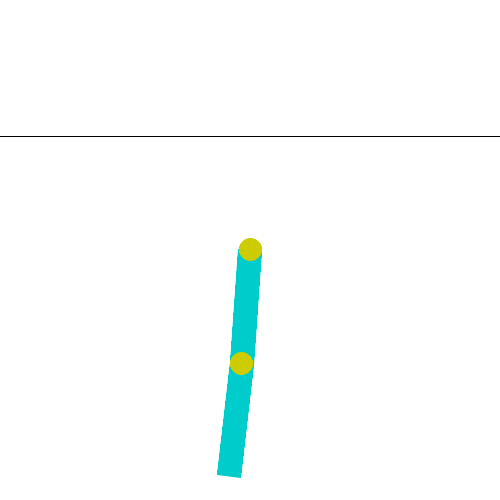

In [4]:
Image(open('trained_agent.gif','rb').read())